# MetPy

MetPy is a collection of tools in Python for reading, visualizing, and performing calculations with weather data. MetPy supports Python >= 3.6 and is freely available under a permissive open source license. More information at https://unidata.github.io/MetPy/latest/index.html

https://unidata.github.io/MetPy/latest/examples/index.html

Tools for unit-aware, meteorological calculations: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html#module-metpy.calc

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT

%matplotlib inline

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
data_path = Path("../data/")

In [3]:
ds = xr.open_dataset(data_path / 'ERA5_temp_rh_West_Africa.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 77, level: 6, longitude: 153, time: 492)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 2020-12-01T12:00:00
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    Conventions:  CF-1.6
    history:      Sat May 22 17:00:08 2021: cdo selday,1 ERA5_temperature_rh_...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

As an example we'll now use `MetPy` to calculate potential temperature using the `mpcalc.potential_temperature` function. For this we will need the *temperature* and the *pressure* at a given point. In ERA5 datasets the pressure is given by the `level` coordinate and as we've seen before temperature is given by the `t` variable.

In [4]:
ds.level

<xarray.DataArray 'level' (level: 6)>
array([ 500.,  600.,  700.,  850.,  925., 1000.])
Coordinates:
  * level    (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z

In [5]:
ds.t

<xarray.DataArray 't' (time: 492, level: 6, latitude: 77, longitude: 153)>
[34777512 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01T12:00:00 ... 2020-12-01T12:00:00
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * level      (level) float64 500.0 600.0 700.0 850.0 925.0 1e+03
Attributes:
    standard_name:  air_temperature
    long_name:      Temperature
    units:          K

You will notice that that the pressure coordinate is only a 1D set of values, but because we are using xarray the correct pressure values are automatically repeated across the time, latitude and longitude coordinates (this is called "broadcasting", and you'll see how to do this manually below). Note that `metpy` doesn't set the `units` and `long_name` netCDF attributes, so you will have to set these yourself if you want units to automatically appear on the plot

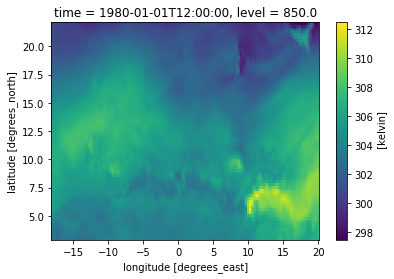

In [6]:
ds_level850 = ds.sel(level=850)

da_theta = mpcalc.potential_temperature(
    pressure=ds_level850.level, temperature=ds_level850.t
)
# metpy adds a special `.metpy` variable to our data-array can grab the units from
da_theta.attrs["units"] = da_theta.metpy.units

da_theta.sel(time='1980-01-01T12').plot()

We'll now see how to manually "broadcast" the pressure values to have these repeated

In [7]:
# Select a portion of the data and use `xr.broadcast` to manually 
# broadcast the pressure values with temperature
da_pressure, da_temperature = xr.broadcast(ds.level.sel(level=850), ds.t.sel(time='1980-01-01T12',level=850))

da_pressure

<xarray.DataArray 'level' (latitude: 77, longitude: 153)>
array([[850., 850., 850., ..., 850., 850., 850.],
       [850., 850., 850., ..., 850., 850., 850.],
       [850., 850., 850., ..., 850., 850., 850.],
       ...,
       [850., 850., 850., ..., 850., 850., 850.],
       [850., 850., 850., ..., 850., 850., 850.],
       [850., 850., 850., ..., 850., 850., 850.]])
Coordinates:
    level      float64 850.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 3.75 3.5 3.25 3.0
  * longitude  (longitude) float32 -18.0 -17.75 -17.5 -17.25 ... 19.5 19.75 20.0
Attributes:
    standard_name:  air_pressure
    long_name:      pressure_level
    units:          millibars
    positive:       down
    axis:           Z

In [ ]:
da_temperature

In [ ]:
# we can now to the calculation as before

da_theta = mpcalc.potential_temperature(pressure=da_pressure, temperature=da_temperature)
da_theta.plot()

## Working with CSV data

When loading data from CSV-files the units of the variables might not be given and won't automaticallly be set when the data is loaded in. To ensure the calculations are correct `MetPy` requires that the `units` attribute is set or provided by multiplying by the correct `units.{...}` variable

Now let us compute the potential temperature for a station data stored in a csv file.

In [ ]:
df = pd.read_csv(data_path / 'Koforidua_sounding_sample.csv', delimiter=',')
df.head()

Before passing in the pressure and temperature values to `mpcalc.potential_temperature` we multiple by the correct `units.{...}` variables to set what the units are

In [ ]:
press = df.pressure.values*units.hPa
temp = df.temperature.values*units.kelvin
theta = mpcalc.potential_temperature(press,temp)
theta

## Creating a skew-T plot

As a final example we will use `MetPy` to produce a skew-T plot from the values we loaded from the CSV-file

In [ ]:
p = df['pressure'].values * units.hPa
T = ((df['temperature'].values)-273.15) * units('degC')
Tv = df['temperature'].values* units('kelvin')
Td = df['dewpoint'].values * units.degC
wind_speed = df['windspd'].values * units('knot')
wind_dir = df['wind_dxn'].values * units.degrees
uwind = df['u'].values * units('m/s').to('knot')
vwind = df['v'].values * units('m/s').to('knot')

##Plot skew-T###
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])  # Calculate the LCL
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0])            # Calculate the parcel profile.

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, uwind, vwind)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
plt.title('Koforidua 06 UTC')

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)               # Plot the parcel profile as a black line
skew.shade_cin(p, T, parcel_prof)                         # Shade areas of CAPE and CIN
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2) # Plot a zero degree isotherm

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

<b>NOTE</b>: The <b>'sharppy'</b> python package can also produce similar sounding profile in an easy convenient way through a graphical user interface. The input data has to be in a specific format such as that in the <b>'June161200.csv'</b> file. The resulting plot is found in the <b>'June161200.png'</b> file Check the installation guide for sharppy for more details: https://sharppy.github.io/SHARPpy/index.html

<b>Exercise 4:</b> 

1. For any pressure level and date of your choice, compute the equivalent potential temperature with metpy. HINT: First compute the dewpoint temperature using relative humidity and temperature.

2. Make a spatial plot of the dewpoint temperature for the entire West Africa.

3. Select a region of your choice and plot the corresponding dewpoint temperature. 

4. From Koforidua_sounding_sample.csv, compute the Brunt-vaisala frequency (N) of the atmosphere. Show into details, a step-by-step of all computations. 

5. Create a plot of the height vs Brunt-vaisala frequency (N), show all necessary components of the plot such as labels on the x and y axis, legend and plot title.

In [ ]:
# 1
ds = xr.open_dataset(data_path / 'ERA5_temp_rh_West_Africa.nc')

# Select a portion of the data
da_temp = ds.t.sel(time='1980-01-01T12',level=850)
da_rh = ds.r.sel(level=850, time='1980-01-01T12')
da_pres = da_temp.level

da_dpt = mpcalc.dewpoint_from_relative_humidity(da_temp, da_rh)

da_theta_e = mpcalc.equivalent_potential_temperature(da_pres, da_temp, da_dpt)
da_theta_e.attrs["units"] = da_theta_e.metpy.units
da_theta_e

In [ ]:
# 2
da_theta_e.plot()

In [ ]:
# 3.
da_theta_e.sel(latitude=slice(12,4), longitude=slice(-5,2)).plot()

In [ ]:
# 4.
df = pd.read_csv(data_path / 'Koforidua_sounding_sample.csv', delimiter=',')
p = df['pressure'].values * units.hPa
heights = df['height'].values * units.meters
T = ((df['temperature'].values)) * units('kelvin')
theta = mpcalc.potential_temperature(p,T)
N = mpcalc.brunt_vaisala_frequency(heights, theta, vertical_dim=0)
N

In [ ]:
# 5.
plt.plot(N, heights)
plt.xlabel('Brunt Vaisala frequency (per second)')
plt.ylabel('Heights (m)')
plt.title('Plot of Brunt-Vaisala')